# Solving the Navier-Stokes equation with tensor-product space-time FEM in FEniCS and equal order dG(r)-discretization for velocity and pressure

In [1]:
# FEniCS for spatial FEM
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

## Create temporal basis in SymPy

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import Mul, Id, symbols, init_printing, expand, compose, diff, lambdify, Piecewise
from IPython.display import Math, display
from fenics import Mesh, VectorElement, Function, TrialFunction, TestFunction, TestFunctions, FunctionSpace, dx, inner, grad, FiniteElement, MixedElement, Constant, assemble, Expression, interpolate, solve, DirichletBC, plot, errornorm, set_log_active, derivative, parameters, split, dot, div
from ufl import replace
import time
import pandas as pd

set_log_active(False) # turn off FEniCS logging
parameters["reorder_dofs_serial"] = False

t = symbols("t")
init_printing()

# HELPER FUNCTIONS
# compute temporal basis functions from the roots
def compute_basis_functions(roots):
    basis = []
    for i in range(len(roots)):
        f = 1 + 0*Id(t)
        for j in range(len(roots)):
            if i != j:
                f = Mul(f,(t - roots[j]) / (roots[i] - roots[j]))
        #basis.append(f)
        basis.append(expand(f))
    return basis

# transform roots from [-1, 1] to [0, 1]
def transform_roots(roots):
    new_roots = []
    for root in roots:
        new_roots.append((root + 1) / 2)
    return new_roots

# dictionary of temporal bases depending on the polynomial degree
# FE basis on reference element (0,1)
φ = {}
roots = {}

roots[0] = [1.]
φ[0] = [1 + 0*Id(t)]
roots[1] = [0., 1.]
φ[1] = [1-t, t]
roots[2] = transform_roots([-1, 0, 1])
φ[2] = compute_basis_functions(roots[2])
#roots[3] = transform_roots([-1, -sqrt(Rational(1,5)), sqrt(Rational(1,5)), 1])
#φ[3] = compute_basis_functions(roots[3])

class TimeFE:
    def __init__(self, r=1, a=0., b=1., n_time=1, n_q_points=3):
        self.r = r # polynomial degree in time
        self.n_time = n_time # number of temporal elements
        self.n_dofs = (self.r+1) * self.n_time # total number of temporal dofs on slab
        self.dof_locations = []
        self.a = a # start time of slab
        self.b = b # end time of slab
        self.k = (self.b - self.a) / self.n_time
        self.epsilon = self.k * 1e-14

        self.generate_mesh()
        self.get_full_basis()
        self.lambdify_basis()
        self.compute_quadrature(n_q_points)

    def generate_mesh(self):
        # create an uniform temporal mesh with mesh size self.k
        self.mesh = [(self.a, self.a+self.k)]
        while len(self.mesh) < self.n_time:
            self.mesh.append((self.mesh[-1][1], self.mesh[-1][1]+self.k))

    # transform basis functions from [0,1] to [a,b]
    def transform_function(self, f, a, b):
        return compose(f, (t-a)/(b-a)) # = f((t-a)/(b-a))
    
    def transform_derivative(self, a, b):
        return 1 / (b-a)

    # get full FE basis and its derivative on temporal mesh
    def get_full_basis(self):
        self._basis = []
        self._basis_derivative = []
        self.local_dofs = {}
        i = 0
        for (a,b) in self.mesh:
            self.local_dofs[(a,b)] = []
            for f, t_q in zip(φ[self.r], roots[self.r]):
                self._basis.append(self.transform_function(f, a, b))
                self._basis_derivative.append(diff(self._basis[-1],t))
                #print(diff(self._basis[-1],t))
                #print(self.transform_function(diff(f,t), a, b) * self.transform_derivative(a, b))
                self.local_dofs[(a,b)].append(i)
                self.dof_locations.append(t_q*(b-a)+a)
                i += 1

    # convert SymPy functions to Python functions and ensure that they are 0 outside the element that they are defined on
    def lambdify_basis(self):
        self.phi = []
        self.dt_phi = []

        for (a,b) in self.mesh:
            for i in self.local_dofs[(a,b)]:
                self.phi.append(
                    lambdify(
                        t,
                        Piecewise(
                            (0, t < a),
                            (0, t > b),
                            (self._basis[i], True)
                        )
                    )
                )

                self.dt_phi.append(
                    lambdify(
                        t,
                        Piecewise(
                            (0, t < a),
                            (0, t > b),
                            (self._basis_derivative[i], True)
                        )
                    )
                )

    def compute_quadrature(self, n_q_points):
        # Gauss-Legendre quadrature points and weights on [-1,1]
        quad_points, quad_weights = np.polynomial.legendre.leggauss(n_q_points)

        # transform quadrature points and weights from [-1,1] to [a,b] for each temporal element [a,b]
        self.quadrature = {}
        for (a, b) in self.mesh:
            t_q = 0.5 * (b-a) * quad_points + 0.5 * (a+b)
            w_q = 0.5 * (b-a) * quad_weights
            self.quadrature[(a,b)] = [(t_q[i], w_q[i]) for i in range(t_q.shape[0])]
            
        # Gauss-Legendre quadrature points and weights on [-1,1]
        quad_points, quad_weights = np.polynomial.legendre.leggauss(n_q_points+2)

        # transform quadrature points and weights from [-1,1] to [a,b] for each temporal element [a,b]
        self.quadrature_fine = {}
        for (a, b) in self.mesh:
            t_q = 0.5 * (b-a) * quad_points + 0.5 * (a+b)
            w_q = 0.5 * (b-a) * quad_weights
            self.quadrature_fine[(a,b)] = [(t_q[i], w_q[i]) for i in range(t_q.shape[0])]

    def plot_basis(self, basis_type="function", title=None):
        assert basis_type in ["function", "derivative"], f"basis_type='{basis_type}' has not been implemented."

        _t = np.linspace(self.a, self.b, 100)
        for i in range(len(self.phi)):
            if basis_type == "function":
                plt.plot(_t, [self.phi[i](time_point) for time_point in _t], label=rf"$\varphi_{{{i}}}$")
            elif basis_type == "derivative":
                plt.plot(_t, [self.dt_phi[i](time_point) for time_point in _t], label=rf"$\partial_t \varphi_{{{i}}}$")

        plt.xlabel("t")
        plt.ylabel("f(t)")
        plt.legend()
        if title is not None:
            plt.title(title)
        plt.show()
        
    def get_solution_at_time(self, time_point, Vh):
        tmp = interpolate(Constant(0.), Vh)
        for i in range(self.n_dofs):
            tmp.vector()[:] += Time.phi[i](time_point) * U.sub(i, deepcopy=True).vector()[:]
        return tmp

## Assemble space-time integrals using numerical quadrature in time and FEniCS forms in space

CONFIG: s = (2/1), r = 1, slab_size = 0.125, n_x = 1


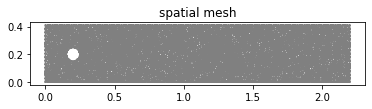

Solving on slab_0 = Ω x (0.0, 0.125) ...
Continue adapting the code here


NameError: name 's' is not defined

In [21]:
##############################################
# Start a time marching / time slabbing loop #
##############################################
start_time = 0.
end_time = 8.

s_v = 2
s_p = 1
r = 1
slab_size = 0.125
n_x = 1

# start simulation
cpu_start_time = time.time()
print(f"CONFIG: s = ({s_v}/{s_p}), r = {r}, slab_size = {slab_size}, n_x = {n_x}")

slabs = [(start_time, start_time+slab_size)]
while slabs[-1][1] < end_time - 1e-8:
    slabs.append((slabs[-1][1], slabs[-1][1]+slab_size))

# get spatial function space
space_mesh = Mesh("schaefer_turek_2D.xml")
plot(space_mesh, title="spatial mesh")
plt.show()
element = {
    "v": VectorElement("Lagrange", space_mesh.ufl_cell(), s_v),
    "p": FiniteElement("Lagrange", space_mesh.ufl_cell(), s_p),
}
Vh = FunctionSpace(space_mesh, MixedElement(*element.values())) # spatial function space for a single time point
Uh = Function(Vh)
Phih = TestFunctions(Vh)

# initial condition on slab
U0 = Function(Vh)
U0 = interpolate(Constant((0.,0.,0.)), Vh)

# split functions into velocity and pressure components
v, p = split(Uh)
phi_v, phi_p = Phih

# preassemble spatial forms
mass_form = dot(v, phi_v) * dx
laplace_form = inner(grad(v), grad(phi_v)) * dx
pressure_form = p * div(phi_v) * dx
div_form = div(v) * phi_p * dx
convection_form = dot(dot(grad(v), v), phi_v) * dx

L2_error = 0.
total_n_dofs = 0
total_time_n_dofs = 0

#####################
# Time slabbing loop:
for k, slab in enumerate(slabs):
    print(f"Solving on slab_{k} = Ω x ({round(slab[0],5)}, {round(slab[1],5)}) ...")

    #########################################
    # Create temporal finite element object #
    #########################################
    Time = TimeFE(r=r, a=slab[0], b=slab[1], n_time=2, n_q_points=r+1)

    print("Continue adapting the code here")
    element_u = FiniteElement("CG", space_mesh.ufl_cell(), s)
    V = FunctionSpace(space_mesh, MixedElement(*[element_u for _ in range(Time.n_dofs)]))

    U = Function(V)
    Phi = TestFunctions(V)

    # start with "empty" space-time variational form
    F = Constant(0.)*U[0]*Phi[0]*dx
    rhs_force = Expression('(1.0/2.0)*(2*pow(t + 1, 2)*exp((1.0/2.0)*t)*sin(pi*x[0]) + (-t + 2*pow(pi, 2)*(t + 1) + 1)*exp(t))*exp(-3.0/2.0*t)*sin(pi*x[0])', degree=4, pi=np.pi, t=0.)

    # volume integrals
    for time_element in Time.mesh:
        # assemble linear terms
        for i in Time.local_dofs[time_element]:
            for j in Time.local_dofs[time_element]:
                for (t_q, w_q) in Time.quadrature[time_element]:
                    # TODO: to reduce the number of terms in the sum, the sum over the temporal quadrature can be evaluated prior to adding to the form F
                    F += Constant(w_q * Time.dt_phi[j](t_q) * Time.phi[i](t_q)) \
                        * replace(mass_form, {uh: U[j], phih: Phi[i]})
                    F += Constant(w_q * Time.phi[j](t_q) * Time.phi[i](t_q)) \
                        * replace(laplace_form, {uh: U[j], phih: Phi[i]})
        # assemble nonlinearity
        for i in Time.local_dofs[time_element]:
            for j in Time.local_dofs[time_element]:
                for l in Time.local_dofs[time_element]:
                    # NOTE: For nonlinearities make sure that the temporal quadrature is fine enough
                    # E.g. for the nonlinearity u^2, we need to be able to integrate polynomials of degree 3r exactly in time
                    #      for this we need Gauss-Legendre quadrature of degree >= (3r+1)/2
                    for (t_q, w_q) in Time.quadrature_fine[time_element]:
                        F += Constant(w_q * Time.phi[j](t_q) * Time.phi[l](t_q) * Time.phi[i](t_q)) \
                            * U[j]*U[l]*Phi[i]*dx     
    # RHS integral
    for n, time_element in enumerate(Time.mesh):
        for i in Time.local_dofs[time_element]:
            # initial condition
            if n == 0:
                F -=  Constant(Time.phi[i](time_element[0]+Time.epsilon)) * u0 * Phi[i] * dx

            for (t_q, w_q) in Time.quadrature_fine[time_element]:
                # forcing function
                #rhs_force.t = t_q
                #F -= Constant(w_q * Time.phi[i](t_q)) * rhs_force * Phi[i] * dx 
                # for debugging:
                F -= Constant(w_q * Time.phi[i](t_q)) * Expression('(1.0/2.0)*(2*pow(t + 1, 2)*exp((1.0/2.0)*t)*sin(pi*x[0]) + (-t + 2*pow(pi, 2)*(t + 1) + 1)*exp(t))*exp(-3.0/2.0*t)*sin(pi*x[0])', degree=4, pi=np.pi, t=t_q) * Phi[i] * dx 


    # jump terms (NOTE: For Gauss-Lobatto dG basis, we can hard code the values for the jump term)
    for n, time_element in enumerate(Time.mesh):
        # a) u_m^+ * φ_m^+
        for i in Time.local_dofs[time_element]:
            for j in Time.local_dofs[time_element]:
                F += Constant(Time.phi[j](time_element[0]+Time.epsilon) * Time.phi[i](time_element[0]+Time.epsilon)) * replace(mass_form, {uh: U[j], phih: Phi[i]})

        # b) u_{m-1}^- * φ_m^+
        if n > 0:
            prev_time_element = Time.mesh[n-1]
            for i in Time.local_dofs[time_element]:
                for j in Time.local_dofs[prev_time_element]:
                    F += Constant((-1.) * Time.phi[j](prev_time_element[1]-Time.epsilon) * Time.phi[i](time_element[0]+Time.epsilon)) * replace(mass_form, {uh: U[j], phih: Phi[i]})       

    # define time dependent Dirichelt boundary conditions
    bcs = []
    for i, t_q in enumerate(Time.dof_locations):
        u_analytical.t = t_q
        if Time.n_dofs > 1:
            bcs.append(DirichletBC(V.sub(i), u_analytical, lambda _, on_boundary: on_boundary))
        else:
            # for dG(0) with 1 temporal element Vh = V
            raise NotImplementedError("Make sure that Time.n_dofs > 1, because otherwise V.sub(i) doesn't work")

    dU = TrialFunction(V)

    # Gateaux derivative of F w.r.t. to U in direction of dU
    J = derivative(F, U, dU) 

    # solve problem
    solve(F == 0, U, bcs) #, tol=5e-6, M=Expression("exp(x[0])", degree=2)*U[0]*dx) # TODO: adapt to adaptive mesh refinement

    # get u0 for next slab
    u0 = Time.get_solution_at_time(slab[1]-Time.epsilon, Vh) #Vh_new)

    # prepare convergence plot
    total_time_n_dofs += Time.n_dofs
    total_n_dofs += Vh.dim() * Time.n_dofs 
    for time_element in Time.mesh:
        for (t_q, w_q) in Time.quadrature_fine[time_element]:
            u_q_FEM = Time.get_solution_at_time(t_q, Vh)
            u_analytical.t = t_q
            u_q_analytical = interpolate(u_analytical, Vh)
            L2_error += w_q * assemble((u_q_analytical-u_q_FEM)**2*dx)
    print("Done.\n")

print("------------")
print("| RESULTS: |")
print("------------")
print(f"Space-time Dofs: {total_n_dofs}")
print("L2 error:", L2_error)
cpu_time = round(time.time() - cpu_start_time, 5)
print(f"CPU Time: {cpu_time} s \n\n")
convergence_table[r, s][Vh.dim(), total_time_n_dofs] = {"dofs": total_n_dofs, "error": f"{np.sqrt(L2_error):.3e}", "time": cpu_time}
